# Data Training, Regularizing, Feature Selection, and Testing

## Packages needed for analysis:

In [3]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# BL: These are just helpful as I debug things
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4]:
# From: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import timesplit as ts

# import our pipeline file [TO DO: NEEDS TO BE UPDATED TO USE OURS]
import pipeline as pline

In [5]:
def read_data(data, date_type=False):
    print(date_type)
    if date_type:
        df = pd.read_csv(data)
    else:
        #parser = lambda date: pd.datetime.strptime(date, '%d%b%Y')
        df = pd.read_csv(data, parse_dates=["date"], dtype={'fips': str})
    return df

X_train = read_data("../Data/Train-Test Set/X_train.csv")
X_test = read_data("../Data/Train-Test Set/X_test.csv")
y_train = read_data("../Data/Train-Test Set/y_train.csv", True)
y_test = read_data("../Data/Train-Test Set/y_test.csv", True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

False
False
True
True
(71992, 16) (17998, 16) (71992, 1) (17998, 1)


In [10]:
from sklearn.model_selection import GridSearchCV

In [6]:
def GridSearchSummary(search, hyperparams, metrics, file):
    """
    Creates a dataframe with summary results from GridSearchCV
    search - the final GridSearchCV object
    hyperparams - thea list of parameters you were tuning for (aka keys in the param_grid dictionary)
    metrics - the list of scoring metrics you used
    file - filename of where you want to save your results
    """
    
    summary = pd.DataFrame()
    
    for hyperparam in hyperparams:
        col = [dct[hyperparam] for dct in search.cv_results_["params"]]
        summary[hyperparam] = col
    
    for metric in metrics:
        col = search.cv_results_["mean_test_" + metric]
        summary[metric] = col
    
    summary.to_csv(file)
    
    return summary

In [13]:
# set up time-based CV indices
tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

tscv_indices = []

for train_index, test_index in tscv.split(X_train, date_column='date'):
    tscv_indices.append((train_index, test_index))

## Ridge Regression

In [7]:
from sklearn.linear_model import Ridge

In [12]:
scoring_metrics = ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"]

In [64]:
from sklearn.preprocessing import PolynomialFeatures

In [65]:
poly_degrees = [2, 3]

In [66]:
param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

for deg in poly_degrees:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly = poly_features.fit_transform(X_train.drop(columns=["date"]))
    ridge_fs_search = GridSearchCV(Ridge(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
    ridge_fs_search.fit(X_poly, y_train)
    GridSearchSummary(ridge_fs_search, 
                      ["alpha"],
                      ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                      "ridge_fs_search_poly_" + str(deg) + ".csv")

In [49]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('poly', PolynomialFeatures(degree=1)),
#                 ('ridge', Ridge())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

ridge_fs_search = GridSearchCV(Ridge(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = "r2")
ridge_fs_search.fit(X_train.drop(columns=["date"]), y_train)

GridSearchCV(cv=[([3, 11, 16, 42, 72, 94, 96, 110, 112, 118, 126, 155, 176, 183,
                   209, 238, 251, 255, 260, 269, 302, 317, 326, 332, 346, 359,
                   386, 397, 437, 443, ...],
                  [37, 64, 266, 442, 457, 527, 533, 563, 581, 644, 681, 711,
                   712, 757, 763, 783, 797, 812, 849, 928, 945, 972, 1024, 1054,
                   1076, 1098, 1117, 1150, 1172, 1203, ...]),
                 ([11, 37, 42, 64, 94, 110, 112, 118, 126, 155, 176, 183, 238,
                   251, 255, 260, 266, 269, 302, 317, 326,...
                   210, 224, 237, 242, 254, 270, 277, 309, 316, 318, 322, 323,
                   324, 340, 371, 375, 382, ...],
                  [25, 58, 104, 174, 263, 275, 303, 349, 531, 575, 593, 627,
                   635, 653, 682, 683, 709, 719, 731, 738, 761, 781, 798, 904,
                   908, 940, 994, 1065, 1151, 1189, ...]), ...],
             estimator=Ridge(),
             param_grid={'alpha': [0, 0.1, 0.2, 0.3,

In [51]:
ridge_fs_search.best_estimator_

Ridge(alpha=1)

In [ ]:
def highlight_max(df):
    for s in df.columns:
        is_max = s == s.max()
        return ['background-color: yellow' if cell else '' for cell in is_max]

In [ ]:
df.style.apply(highlight_max)

In [50]:
GridSearchSummary(ridge_fs_search, 
                  ["alpha"],
                  ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                  "ridge_fs_search.csv")

,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0.0,-1449.567209,0.930522,-8.384891
1,0.1,-1448.226533,0.930577,-8.377315
2,0.2,-1446.942107,0.930623,-8.370642
3,0.3,-1445.707053,0.930662,-8.364612
4,0.4,-1444.515676,0.930694,-8.359215
5,0.5,-1443.363213,0.930720,-8.354459
6,0.6,-1442.245646,0.930742,-8.350061
7,0.7,-1441.159556,0.930760,-8.345975
8,0.8,-1440.102012,0.930773,-8.342280
9,0.9,-1439.070483,0.930784,-8.338975


In [52]:
rid = pd.read_csv("ridge_fs_search.csv")

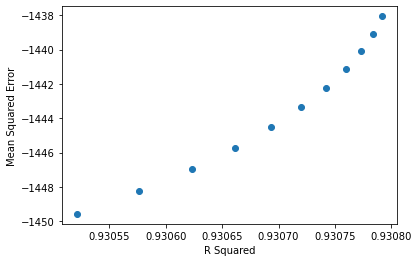

In [53]:
plt.scatter(rid['r2'], rid['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

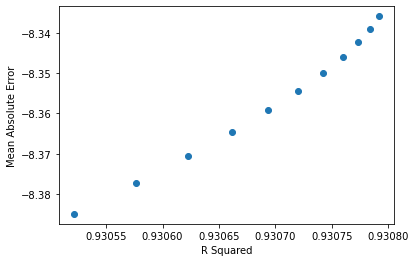

In [55]:
plt.scatter(rid['r2'], rid['neg_mean_absolute_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Absolute Error")
#plt.title()
plt.show()

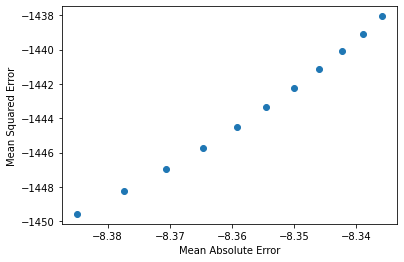

In [54]:
plt.scatter(rid['neg_mean_absolute_error'], rid['neg_mean_squared_error'])
plt.xlabel("Mean Absolute Error")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

In [68]:
ridge_2 = pd.read_csv("ridge_fs_search_poly_2.csv")

In [70]:
ridge_2

,Unnamed: 0,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.5,-13133.062963,0.625173,-10.196844
1,1,0.6,-12840.067590,0.635000,-10.130550
2,2,0.7,-12574.252468,0.643319,-10.075912
3,3,0.8,-12331.852356,0.650518,-10.027989
4,4,0.9,-12109.737125,0.656855,-9.984511
5,5,1.0,-11905.279251,0.662507,-9.944834


In [72]:
ridge_3 = pd.read_csv("ridge_fs_search_poly_3.csv")

In [73]:
ridge_3

,Unnamed: 0,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.5,-4.553875e+06,-124.998887,-66.449261
1,1,0.6,-4.257768e+06,-113.235347,-64.172852
2,2,0.7,-4.010322e+06,-104.146474,-62.445897
3,3,0.8,-3.798256e+06,-96.861182,-60.978657
4,4,0.9,-3.613048e+06,-90.855834,-59.703533
5,5,1.0,-3.448881e+06,-85.794602,-58.562419


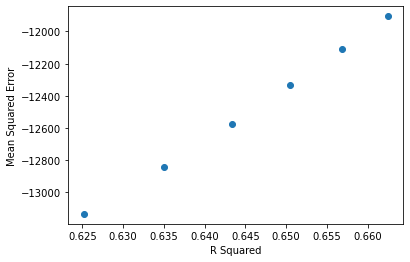

In [69]:
plt.scatter(ridge_2['r2'], ridge_2['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

## Lasso Regression

In [56]:
from sklearn.linear_model import Lasso

to avoid lasso warnings, either increase tol or increase max_iter

In [79]:
from sklearn.pipeline import make_pipeline

not sure if this is okay. did not use tscv_indices here

In [ ]:
param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

for deg in poly_degrees:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly = poly_features.fit_transform(X_train.drop(columns=["date"]))
    ridge_fs_search = GridSearchCV(Ridge(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
    ridge_fs_search.fit(X_poly, y_train)
    GridSearchSummary(ridge_fs_search, 
                      ["alpha"],
                      ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                      "ridge_fs_search_poly_" + str(deg) + ".csv")

In [84]:
param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

for degree in [2, 3]:
    #for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_train.drop(columns=["date"]))
    #model = make_pipeline(PolynomialFeatures(degree), Lasso())
    lasso_fs_search = GridSearchCV(Lasso(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
    lasso_fs_search.fit(X_poly, y_train)
    GridSearchSummary(lasso_fs_search, 
                  ["alpha"],
                  ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                  "lasso_fs_search_" + str(degree) + ".csv")

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11567.267905812027, tolerance: 1093.6789065647658
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25127.481783745083, tolerance: 1062.1047228521334
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75526.66141077202, tolerance: 1057.9517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66938.35952433496, tolerance: 1728.2196339702764
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33756.196217598124, tolerance: 1123.6358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14781.027597336564, tolerance: 994.6315509228679
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 919317.5433157465, tolerance: 32547.49899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 996027.5243677124, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 965181.6661934304, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1987.54137850806, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33735.64380265592, tolerance: 1234.903780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172080.7954365857, tolerance: 1951.2211614474193
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99709.69966470082, tolerance: 2307.941166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167258.99693833917, tolerance: 3254.4261289920073
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204709.4527793318, tolerance: 3500.126822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 878377.2745328508, tolerance: 8311.453083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90810.1108268023, tolerance: 4794.9011456814205
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58706.472686471505, tolerance: 2768.306754191675
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 786857.8389498808, tolerance: 32547.49899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 973085.0471509751, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 977465.9347382663, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12884.56724701845, tolerance: 4010.1279683985204
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165580.36210290354, tolerance: 8483.260302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 899389.4314396046, tolerance: 18817.24270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151745.47842264036, tolerance: 3273.256702535811
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68824.37874771695, tolerance: 2583.7180749565546
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86835.48698123684, tolerance: 1917.5813833949053
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28272.50446676454, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54374.36611380466, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16565.00742727326, tolerance: 2307.941166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39500.32626012486, tolerance: 4794.9011456814205
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59491.094418347115, tolerance: 2768.306754191675
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4142.76389814209, tolerance: 1728.2196339702764
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589416.6841392722, tolerance: 13926.656206422906
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 874116.8178739022, tolerance: 14198.965230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1328075.8106018729, tolerance: 14556.261914048953
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 851271.4441926341, tolerance: 38759.875927840694
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495714.02321838855, tolerance: 32547.49899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 863325.7434140389, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209053.808304166, tolerance: 895.1713972568093
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181028.67659147707, tolerance: 849.654052705061
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105460.85994728522, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75016.3446971557, tolerance: 1002.4509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84517.73788310088, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132076.05692795917, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 901436.3324206863, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 892698.4362127003, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 797062.5424392606, tolerance: 18306.07887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246793.77296708614, tolerance: 895.1713972568093
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206137.15763920711, tolerance: 849.654052705061
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175769.17049719323, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102744.10231683095, tolerance: 1002.4509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116932.91222708122, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164584.47395524735, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1110529.4823611337, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1104544.7629588554, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 968905.271277555, tolerance: 18306.07887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252983.51326946224, tolerance: 895.1713972568093
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169255.1291021817, tolerance: 849.654052705061
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198250.01549372528, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77344.0068022994, tolerance: 1002.4509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116431.80109809204, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200934.6771171685, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1289925.1790749007, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1287533.2449751983, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1095410.7875124952, tolerance: 18306.07887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286678.9097308024, tolerance: 895.1713972568093
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212972.628386532, tolerance: 849.654052705061
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230158.84512830552, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99857.88928044942, tolerance: 1002.4509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124283.49739992735, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213043.04310607637, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1442843.6001236006, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1448492.9129909622, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219818.1976721187, tolerance: 18306.07887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285516.70521258167, tolerance: 895.1713972568093
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206644.54057719343, tolerance: 849.654052705061
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239641.09246888058, tolerance: 821.9428393325619
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115011.46318274055, tolerance: 1002.4509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147965.48738428226, tolerance: 1038.1291794334497
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224392.69950887904, tolerance: 1436.8272327683612
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1594959.6419625648, tolerance: 27466.594954342338
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1590629.633160416, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1335462.9054774465, tolerance: 18306.07887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

In [86]:
lasso_2 = pd.read_csv("lasso_fs_search_2.csv")

In [87]:
lasso_2

,Unnamed: 0,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.1,-3456.759656,0.895513,-8.040768
1,1,0.2,-3330.019443,0.893773,-8.115259
2,2,0.3,-3045.828948,0.894638,-8.230035
3,3,0.4,-2781.234013,0.896075,-8.341743
4,4,0.5,-2578.698259,0.899349,-8.460835
5,5,0.6,-2502.615078,0.900395,-8.595758
6,6,0.7,-2437.998312,0.900498,-8.734700
7,7,0.8,-2380.048064,0.899888,-8.876771
8,8,0.9,-2285.617441,0.899594,-9.013737
9,9,1.0,-2173.838297,0.899687,-9.143417


In [88]:
lasso_3 = pd.read_csv("lasso_fs_search_3.csv")

In [89]:
lasso_3

,Unnamed: 0,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.1,-48951.109447,-1.798038,-11.015063
1,1,0.2,-37540.784549,-0.841542,-10.575967
2,2,0.3,-24838.064060,0.149653,-9.974899
3,3,0.4,-21847.801776,0.486482,-9.718587
4,4,0.5,-20752.128564,0.615250,-9.494871
5,5,0.6,-20429.623325,0.627149,-9.575253
6,6,0.7,-19693.525729,0.640892,-9.656653
7,7,0.8,-18949.202107,0.654164,-9.760062
8,8,0.9,-18048.221703,0.668182,-9.832119
9,9,1.0,-17619.718977,0.675737,-9.902643


In [57]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('lasso', Lasso())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

lasso_fs_search = GridSearchCV(Lasso(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = "r2")
lasso_fs_search.fit(X_train.drop(columns=["date"]), y_train)

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67700.83293301985, tolerance: 22654.373863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15298.399453472346, tolerance: 13926.656206422906
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24175.25185217848, tolerance: 14198.965230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

GridSearchCV(cv=[([3, 11, 16, 42, 72, 94, 96, 110, 112, 118, 126, 155, 176, 183,
                   209, 238, 251, 255, 260, 269, 302, 317, 326, 332, 346, 359,
                   386, 397, 437, 443, ...],
                  [37, 64, 266, 442, 457, 527, 533, 563, 581, 644, 681, 711,
                   712, 757, 763, 783, 797, 812, 849, 928, 945, 972, 1024, 1054,
                   1076, 1098, 1117, 1150, 1172, 1203, ...]),
                 ([11, 37, 42, 64, 94, 110, 112, 118, 126, 155, 176, 183, 238,
                   251, 255, 260, 266, 269, 302, 317, 326,...
                   210, 224, 237, 242, 254, 270, 277, 309, 316, 318, 322, 323,
                   324, 340, 371, 375, 382, ...],
                  [25, 58, 104, 174, 263, 275, 303, 349, 531, 575, 593, 627,
                   635, 653, 682, 683, 709, 719, 731, 738, 761, 781, 798, 904,
                   908, 940, 994, 1065, 1151, 1189, ...]), ...],
             estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.

In [63]:
lasso_fs_search.best_estimator_

Lasso(alpha=0.1)

In [58]:
GridSearchSummary(lasso_fs_search, 
                  ["alpha"],
                  ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                  "lasso_fs_search.csv")

,alpha,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0.1,-1435.458769,0.930405,-8.213131
1,0.2,-1441.624852,0.927926,-8.213640
2,0.3,-1443.965128,0.925581,-8.244219
3,0.4,-1440.947260,0.923547,-8.290173
4,0.5,-1434.588532,0.921974,-8.334526
5,0.6,-1432.749239,0.919867,-8.394628
6,0.7,-1431.174854,0.917712,-8.455096
7,0.8,-1433.575020,0.915094,-8.528377
8,0.9,-1437.567026,0.912308,-8.603680
9,1.0,-1442.346238,0.909355,-8.682468


In [59]:
lasso = pd.read_csv("lasso_fs_search.csv")

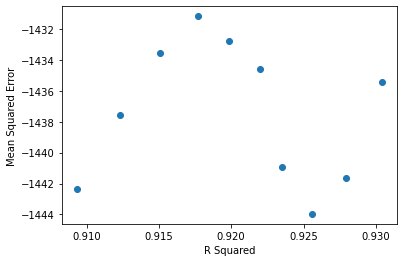

In [60]:
plt.scatter(lasso['r2'], lasso['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

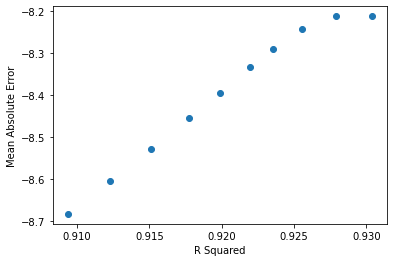

In [61]:
plt.scatter(lasso['r2'], lasso['neg_mean_absolute_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Absolute Error")
#plt.title()
plt.show()

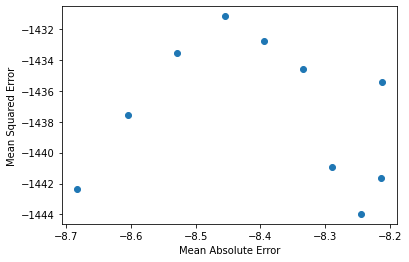

In [62]:
plt.scatter(lasso['neg_mean_absolute_error'], lasso['neg_mean_squared_error'])
plt.xlabel("Mean Absolute Error")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

## Elastic Net

In [20]:
from sklearn.linear_model import ElasticNet

In [37]:
#pipe = Pipeline([#('feature_selection', SelectKBest(mutual_info_regression)),
#                 ('ridge', Ridge())])

param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'tol': [0.001]
}

#print("Start: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

elastic_net_fs_search = GridSearchCV(ElasticNet(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = "r2")
elastic_net_fs_search.fit(X_train.drop(columns=["date"]), y_train)

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313813.0019027069, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354120.3942099166, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 426174.33781230875, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254846.2611063177, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209942.89000992532, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184202.0267721373, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4151038.265954691, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3288479.87903831, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3242048.9064929252, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 663171.2895880339, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638114.7969280997, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534391.3031831709, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351244.26769978064, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 628958.9361379043, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 816006.432510096, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4559183.668849879, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3177676.0871600355, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5323706.270568182, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691346.7713704907, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 998637.488171567, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1794209.7317212482, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1272506.1466870508, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1241957.2422908007, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1260483.728514925, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6434055.269988686, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6368229.031631963, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4069400.7551428806, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2875824.9711386594, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5723971.72178117, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12785502.457255239, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1141837.3800712863, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 903983.2832644522, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 810858.0956848719, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2584188.858444319, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1605658.0536613986, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1100093.240685886, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13986589.725800777, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13767878.950047035, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12039728.602276053, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1036900.0277692289, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1081622.9260651546, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1162002.4738961214, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 843218.3812780837, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716189.5737150217, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 680341.2427955535, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

GridSearchCV(cv=[([3, 11, 16, 42, 72, 94, 96, 110, 112, 118, 126, 155, 176, 183,
                   209, 238, 251, 255, 260, 269, 302, 317, 326, 332, 346, 359,
                   386, 397, 437, 443, ...],
                  [37, 64, 266, 442, 457, 527, 533, 563, 581, 644, 681, 711,
                   712, 757, 763, 783, 797, 812, 849, 928, 945, 972, 1024, 1054,
                   1076, 1098, 1117, 1150, 1172, 1203, ...]),
                 ([11, 37, 42, 64, 94, 110, 112, 118, 126, 155, 176, 183, 238,
                   251, 255, 260, 266, 269, 302, 317, 326,...
                  [25, 58, 104, 174, 263, 275, 303, 349, 531, 575, 593, 627,
                   635, 653, 682, 683, 709, 719, 731, 738, 761, 781, 798, 904,
                   908, 940, 994, 1065, 1151, 1189, ...]), ...],
             estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0

In [39]:
elastic_net_fs_search.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1, tol=0.001)

In [40]:
GridSearchSummary(elastic_net_fs_search, 
                  ["alpha", "l1_ratio"],
                  ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                  "elastic_net_fs_search.csv")

,alpha,l1_ratio,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0.1,0.0,-1201.863136,0.914382,-8.908714
1,0.1,0.1,-1196.972767,0.915117,-8.861287
2,0.1,0.2,-1192.719479,0.915888,-8.810556
3,0.1,0.3,-1189.654017,0.916733,-8.758637
4,0.1,0.4,-1189.142098,0.917567,-8.706644
...,...,...,...,...,...
105,1.0,0.6,-1367.966297,0.901326,-9.735073
106,1.0,0.7,-1330.231431,0.903025,-9.561821
107,1.0,0.8,-1283.738114,0.905136,-9.358467
108,1.0,0.9,-1250.067244,0.907556,-9.102790


In [41]:
elastic = pd.read_csv("elastic_net_fs_search.csv")

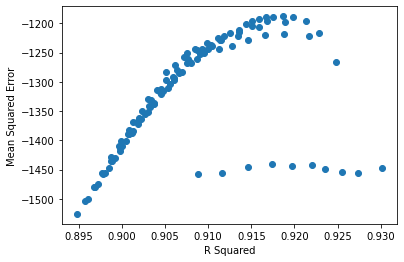

In [44]:
plt.scatter(elastic['r2'], elastic['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

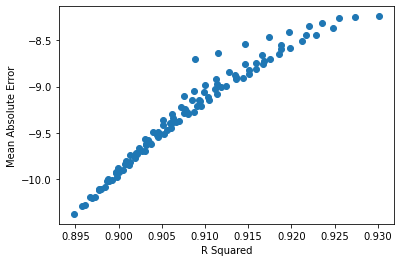

In [46]:
plt.scatter(elastic['r2'], elastic['neg_mean_absolute_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Absolute Error")
#plt.title()
plt.show()

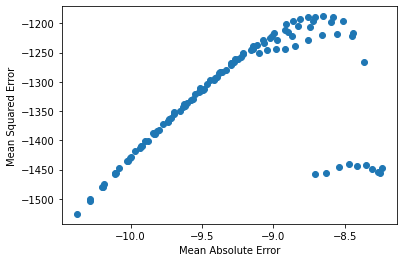

In [47]:
plt.scatter(elastic['neg_mean_absolute_error'], elastic['neg_mean_squared_error'])
plt.xlabel("Mean Absolute Error")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

In [90]:
poly_degrees

[2, 3]

In [ ]:
pd.set_option('display.max_rows', None)

In [91]:
param_grid = {#'feature_selection__k': [20, 30, 50],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'tol': [0.001]
}

for deg in poly_degrees:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly = poly_features.fit_transform(X_train.drop(columns=["date"]))
    elastic_net_fs_search = GridSearchCV(ElasticNet(), param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = "r2")
    elastic_net_fs_search.fit(X_poly, y_train)
    
    GridSearchSummary(elastic_net_fs_search, 
                      ["alpha", "l1_ratio"],
                      ["neg_mean_squared_error", "r2", "neg_mean_absolute_error"],
                      "elastic_net_fs_search_poly_" + str(deg) + ".csv")

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192870.44765743046, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238840.5710140122, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312837.03535656363, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234887.91997823655, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174041.53708608268, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142138.85707957062, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216587.4198016124, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1855775.2302874783, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649724.740187394, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143246.20512078688, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175139.30418229545, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203790.47629678692, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192901.8601859372, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134080.81128701274, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107922.21204550259, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2058728.4551896194, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695951.376629744, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1525568.9850742253, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109659.04176931565, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104234.56247253148, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158465.17139287622, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160543.2390338757, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96881.387297212, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83458.00038012024, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886587.854420014, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1525297.365630731, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1387266.3271997373, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62024.49140817762, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62479.92608660928, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137887.58753967058, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138818.92781842538, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76227.57888557756, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63749.6370742031, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1686244.5112471953, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1329122.660675331, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222862.5345373643, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58969.33791652846, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43442.17276310234, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146622.99010964506, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110883.94609157323, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57396.62460214755, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32943.10236299361, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1444118.1150322706, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1063845.4037178198, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 999146.6760109335, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11567.267905812027, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25127.481783745083, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75526.66141077202, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66938.35952433496, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33756.196217598124, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14781.027597336564, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2508308.1551857684, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227597.0809736564, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2178626.216707648, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190425.22678060256, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285770.34270990983, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352419.1174461354, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198970.65323542393, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149794.8502003994, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123851.6754749791, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2269764.1142898765, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2046052.28706095, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2007264.9775821478, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100414.09424031692, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57920.112155486364, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264379.7030003272, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132877.46207935666, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78751.57579054011, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82653.36243081169, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2024390.525576437, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1851327.405923405, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1818103.5676784876, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83709.22615307433, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12771.853424798348, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152254.3949096157, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54275.61468647975, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62546.781593722175, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60957.691589115275, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1599783.4021413424, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1514119.2220904306, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251568.200495173, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81991.60606557096, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86728.9190250122, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133580.04444173435, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89753.49954100922, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143335.2953790037, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182025.66578435648, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1444202.4968649982, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242523.4059871146, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1862130.9968058772, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283913.04144394037, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1239380.026953763, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1520054.7160457508, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136959.9993058972, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126516.26653886358, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108987.13884708445, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32335.453982489664, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21898.18608324582, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25991.814007624504, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2623014.2011669707, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2548871.5715107583, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2315896.681366097, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249313.48880297857, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348843.579963311, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330082.99096401315, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161092.0010346154, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131837.90991409088, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134495.65568618022, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2384189.9950254653, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2332778.0803590007, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2125535.1715010665, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33940.415714244475, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137811.67535051017, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205274.2809400999, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82196.24150972118, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67193.7054287914, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66146.91480428161, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2133603.852270856, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098023.063747293, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1912807.0862458877, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82652.65678744862, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88148.18698210712, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24608.459618894034, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29052.121715348563, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126036.24922620291, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140458.97675293585, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817598.7689402539, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2666968.772114693, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1849736.3511638648, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1641819.2554014511, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2237850.398284413, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2218078.2277004183, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125557.1012065778, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122363.77687535727, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50735.56329508324, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50010.13390082627, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96466.73022448758, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241068.15658575605, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1572970.862952278, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1027634.9345975274, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155766.08062055797, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938826.4704191711, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006073.6441582837, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039907.9922907294, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450351.2188426915, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 382102.28991123015, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383360.8890762809, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187377.3412186653, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282813.3452209765, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335546.07578720036, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2458165.053106034, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2102654.4023289625, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1854553.4574172525, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249740.6737835782, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177791.81551294087, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68866.52391112008, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90116.23843879324, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201501.60354067356, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225767.0302011933, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216808.566447042, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1863640.982947558, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1589598.3403085056, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93710.17865686608, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41181.983990967914, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16713.035367529083, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43310.23683495303, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147226.86184470466, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129373.9326934786, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1354015.5882557048, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2029698.616086139, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2915990.70281167, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129415.49551604432, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471924.0875967463, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1784591.0661297226, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196758.52340128153, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91045.07607554257, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120582.14505751384, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31133.40107155504, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31540.832755807758, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35167.99533935456, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 971810.227219239, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1633811.314644955, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242995.160704674, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1388780.4272856251, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1244639.8638234779, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1342302.7138806866, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44369.151559910504, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122198.57380162319, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103209.20476395014, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89150.22732391409, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20847.388383339683, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312946.9938844454, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 879377.6445698056, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632024.335397444, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443707.0872263007, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2699657.6016877163, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3644912.2837271504, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3801178.566677497, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263414.00606316776, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231010.38163064755, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69742.70707329802, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 578144.3956356965, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333064.9151248359, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260535.8432088665, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387745.61874547, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3338752.72472875, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3383975.5941071464, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143334.02672378207, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135806.71981095008, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15897.193702399905, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398498.137021118, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248851.49302189823, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77765.07434969197, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2966652.3821568494, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2958195.6784481592, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2474218.6305536996, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83634.58940142114, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14501.683230651659, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62485.60173901642, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35773.71106110365, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19785.971010509675, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83338.60579349639, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1708200.298557845, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 892067.9869713987, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190684.81369647314, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1768189.3260474992, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1463702.9190016945, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1291979.2312797676, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409895.733641102, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1221650.8121068086, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1496394.2237139188, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1392892.214788264, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223741.7999632852, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 890130.1596279151, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484994.25209774455, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 528995.508367317, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 503825.5623643764, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265626.7698996989, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226304.30439006592, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216085.04653460573, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3258977.29116666, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3177288.5825865585, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2817367.1186014814, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70497.11932930135, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201717.4110937932, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216261.6597214349, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132124.43207406264, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118177.95801450501, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83197.49381289136, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2790018.7500183634, tolerance: 325474.9899774319
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2842334.4398369105, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2456396.9614859116, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24116.73876734369, tolerance: 10579.517295538672
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100963.14403780713, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44580.635053818114, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57604.26791557533, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63114.25782790202, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42729.69845206931, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2075272.2838591607, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1814419.4287136123, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1454323.808225322, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21138.937114514294, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62347.62592795922, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104783.68144477054, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222943.59413514292, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228583.77640792387, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213935.7148812025, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27438.103743416403, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26947.40289811365, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58036.59272216121, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124474.01667784329, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140695.22215655155, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16262.150752787944, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897734.6564517024, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603427.8473522969, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77212.887320893, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1490423.4622478879, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 902566.4286249212, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 727942.9646055734, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4258614.267369039, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4531279.34781254, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4102973.003668465, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290183.07663654536, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162270.58391217794, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213966.8735598873, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439946.5763151855, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322459.98198983376, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222580.82578373727, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3860728.567571207, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3963461.8317246176, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3530753.249799898, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199477.75568764424, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36112.68326978263, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53587.58842134604, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207705.9375072433, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134647.41816837096, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94116.64305227756, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3469610.426175526, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3435821.8084090087, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2971548.053908067, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164991.9440456431, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17737.77217862947, tolerance: 10936.789065647657
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23657.52066975023, tolerance: 10621.047228521333
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51337.102450298844, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59471.96431892901, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27139.51929352939, tolerance: 9946.315509228678
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2420664.8864589822, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1668164.5384548053, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1692807.6877943994, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260093.4227841528, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1361630.3706788737, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2793786.2561153076, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108771.39795186627, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135046.87932874652, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41802.74568801126, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145559.9943021327, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207550.75968851522, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193779.2585495959, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50210.857076057524, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34353.86103279417, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158572.22474825708, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54374.36611380466, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190769.037242293, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242714.26492240257, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2621033.327095064, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3637905.0938780205, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4755350.905945711, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209059.80006497115, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73273.37781656289, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521252.11652526143, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277910.0868405539, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440801.7684211107, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455302.16779681505, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2095294.608369902, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2916851.8823036673, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4164870.644868086, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69668.48399871739, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72967.4233969308, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242413.57339287072, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179829.82596528673, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298194.35114079696, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332793.1033690523, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1703130.6568173263, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2208591.953608325, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3566371.9432104416, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11099.946612603031, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30228.4568978732, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99210.7633180262, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105836.12882460645, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221059.70359911348, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245579.75646411898, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1627812.268845813, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 819387.4789581202, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223860.1664649747, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2104666.6315490855, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1524791.1594979109, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1486437.9883000022, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2665534.587168463, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2479921.7963611283, tolerance: 399653.00115702
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2064350.9309315337, tolerance: 387598.7592784069
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165721.52632903866, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1160964.5546947338, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2390292.6260414543, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36107.59756347968, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 846103.6262471672, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1688504.4266282406, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588446.9491466619, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562270.9870392622, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481166.5389214149, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260149.47463102159, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250694.37361850165, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366444.2491097781, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3639676.7861895007, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3162133.7841934017, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2780295.098716055, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206644.91624906723, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222619.20920603516, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210597.3485629909, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119913.77710282382, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84304.50759502203, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148938.25511837876, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160530.5378050795, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2568695.3874553475, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2323284.620985688, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73977.6495174272, tolerance: 8951.713972568094
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90684.12716781441, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80743.94381781132, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59509.561252355285, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66508.31419838182, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111894.90775821678, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2718586.985679896, tolerance: 274665.94954342337
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2020077.289295874, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1892341.095253625, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24511.28006930265, tolerance: 8496.540527050609
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27232.136290817405, tolerance: 8219.42839332562
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29516.32898240944, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70931.4522930106, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165802.86777422862, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221767.99789804444, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97251.47754030081, tolerance: 27683.067541916746
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21410.786466198508, tolerance: 17282.196339702765
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24115.8451639564, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2276572.1288217967, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 957776.5265275277, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535216.5001477494, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1020328.1471122816, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 752340.5260738614, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1331470.0515134255, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 813641.9939400454, tolerance: 226543.73863285215
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 799093.0511142517, tolerance: 183060.7887298191
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589416.6841392722, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1034105.4656384636, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1568790.4947959168, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535754.0393556333, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616905.8321218624, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495526.5878690308, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401954.4234528962, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3523680.1132981274, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2167038.0260211905, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 871473.5585619549, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358232.4321798439, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097440.584236922, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2844776.9367866963, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323311.14723559126, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212636.21072767166, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231574.37571598004, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2425105.306370938, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455668.3686166825, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318674.84705637686, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94912.80560782657, tolerance: 40101.2796839852
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 763464.8999674164, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2165791.9538873453, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260391.76964692122, tolerance: 32732.567025358112
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125407.95861827733, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162635.2835594478, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1610285.4070095285, tolerance: 125060.58099941871
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 882023.4152000225, tolerance: 83114.53083167931
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217116.191510587, tolerance: 47949.0114568142
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445502.2453766946, tolerance: 84832.60302321047
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1558360.3515181025, tolerance: 188172.4270107928
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2570873.2529990226, tolerance: 311436.519992977
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92811.8156541888, tolerance: 25837.180749565545
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171082.6643312869, tolerance: 19175.81383394905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51679.872266825754, tolerance: 12055.312653241654
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31813.198768956558, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64211.89070240711, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47755.2788349404, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13516.19310223707, tolerance: 11236.358916376978
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18306.4782904124, tolerance: 10024.509629751747
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17395.92516683659, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26772.15348955916, tolerance: 10381.291794334498
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25113.016001952114, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23964.318859961408, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29854.229328593123, tolerance: 14368.272327683613
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32380.003898385912, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97235.31958431506, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 928589.530866011, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1690557.0748455764, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2299410.589850186, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227213.85164907447, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266231.67265203595, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354476.58460700343, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185082.97352965453, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223164.1233893904, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223531.87828756223, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 894013.4510324899, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1647588.9397384184, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2254101.075554365, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227515.97296191854, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257935.12106876672, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338692.42847819946, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187356.08251719916, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222113.3657386078, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220260.71379063267, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 851068.6385254669, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1595790.9488925883, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2199120.3000501185, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220468.8557684058, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246064.40389004472, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317330.6770117639, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186431.40808418987, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216216.29491957184, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215287.9227811223, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 796580.9289956985, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1531779.5356857704, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2130169.620893978, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204302.08816286412, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235713.2361635333, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294062.16808065784, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182170.32644217493, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208757.87130011042, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205336.3593851594, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722210.5760532101, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1447788.68771229, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2037598.3470966788, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182322.4491389228, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224853.59280773974, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299633.0417321401, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172329.84427584417, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191784.0330295071, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186789.6714772466, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593429.5890376739, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1309589.5320180913, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1873499.010006411, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270858.00880724913, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314528.1620838946, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425046.79228436877, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223694.4450434661, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274574.4181959606, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280695.29056625685, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1142828.1902414188, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1940753.467502616, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2569688.1896769153, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273315.8130236009, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314142.5187576475, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415862.0414375757, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232038.5069319193, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280104.3980569053, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281709.84516782657, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099579.0696419158, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1887180.664965389, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2513133.2438354245, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263589.8678025175, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302601.80986827775, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395817.1893186086, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232879.99474592847, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277950.69641059474, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275150.7933741419, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039406.8499156074, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817892.3910242324, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2437571.602709223, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231647.26840048397, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266965.4048645695, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365091.19068782043, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228094.74641904913, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270624.8328253233, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261219.6518525322, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952464.5323841197, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1719214.8719790843, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2332532.4022907754, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174714.14217536032, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 269017.17623223655, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330884.96119348047, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215339.92999781686, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260758.32324455888, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232909.58531277924, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 810664.2372839173, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1556170.9861198496, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2168118.062999447, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129455.3998672389, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196651.80634449853, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265455.0068927108, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173097.82236607186, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209783.41629118135, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193752.7416719749, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1331395.1758138554, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2165997.4080513325, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2804381.260057004, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302825.79024925415, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348538.1918431204, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465534.35239376343, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260587.38372330193, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 314721.147560816, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323009.7992805283, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1297974.6190462292, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2116519.4711386645, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2752513.216873809, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294094.68324776844, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343564.20433209016, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463712.7931529342, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266911.39293072803, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305815.72720656154, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321827.10661551316, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1244881.6193157507, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2049849.6489894954, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2682625.843613021, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255069.06621981593, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305791.2406502812, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441939.12343694066, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258957.8684107029, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318546.70010454545, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309915.50305015827, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165272.7794425415, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1955865.6087978538, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2582334.02273521, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195972.32158875733, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 308845.97943728964, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391878.3817970732, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249171.6800155186, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296540.7483159333, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293700.3903681323, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1034315.5984179585, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1795349.421190144, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2430544.210154172, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162397.67133609703, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248041.60006629868, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354811.03954502277, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220290.546787807, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284062.31597744103, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276652.83481686097, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733147.813904092, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1485398.7774634098, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2109571.916829248, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320567.93157730857, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370152.48920075095, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508043.1840158177, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275554.3689789637, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342891.99560755386, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352520.3347007689, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1459931.0479709478, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313255.9014440626, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2952454.0447163284, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 320428.73709985893, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376817.4511561462, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509485.2985602267, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 289371.632255725, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350049.05061946274, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344670.85675173334, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1420277.6658633165, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257825.714291564, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2889968.80864434, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282037.17306452605, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348091.3067073596, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501391.4333468429, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291616.7543314165, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354219.1574617446, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365355.6305924875, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1353199.1576454872, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2164658.112516232, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2808389.5300511764, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219922.8999577325, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334073.4272505814, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447012.1828556149, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281704.8199062012, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353260.9640600555, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347076.6396403915, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1243336.6540215574, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2021930.2875324325, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2675867.3423603256, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225438.13712610386, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325471.9756389453, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414456.41847226105, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261704.91883275512, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346004.08600705245, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325909.2573960562, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1038426.689772229, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1774734.0156615674, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2450288.8692201814, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147699.97377381107, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228116.05670771006, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221836.85686220627, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220562.5710252814, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272923.82175567036, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292333.4473638195, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1591176.807010971, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2470723.9627552815, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120014.651713271, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340268.8078307726, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397886.7500520507, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543119.4653554902, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303901.4350725796, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378633.4950428539, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379656.6711933873, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1568754.982345895, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2439226.8944578655, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3074983.4729086207, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313454.319074854, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380511.1332243638, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543247.138912934, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313740.62907272356, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 381443.163129403, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390914.5113429789, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1519261.5967503558, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2353946.1033933912, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2991935.3517804733, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263442.78537993925, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350099.7406572087, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 479888.88741176424, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311857.4182346077, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392900.82095418393, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408288.90087269957, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1429320.81039478, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239179.4065489774, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2893987.740964271, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211472.91844638233, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354938.2131845746, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497059.9076439493, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299044.9941524846, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393208.47213095194, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399092.1632943442, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1262744.9467936072, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2070487.9560241308, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2712322.329146316, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210641.98056303296, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263641.42099122587, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404659.2965536131, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250162.612548173, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 363238.96946486045, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347748.8937335821, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876423.7810286949, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1608681.2698222164, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2273168.0894394526, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353199.13285970024, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407738.2472433525, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561573.8906318268, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309543.22234869027, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 388619.354469741, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403759.24657404283, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1691565.793277214, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2587263.3232802777, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3234072.946997363, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341241.42320646317, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414215.80729895644, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570687.1173319424, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327956.1218730637, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410049.8308095847, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411973.83307628194, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1661289.1054010582, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2537085.066334027, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3176290.4640106293, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279562.187919792, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370230.6747941587, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522172.6437445614, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332430.67389926943, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412931.1675141512, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434473.8168395791, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1594084.9494974054, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2435266.0743036265, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3075902.758534977, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229480.35035474863, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360253.52229445736, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533507.9912490408, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329554.40738340665, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420438.0132945484, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440099.86310393154, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461028.7167875331, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2289870.9875589013, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2946778.3579997327, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209980.56644431612, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335717.73103381053, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480628.519303884, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286321.1360391212, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413611.8467429485, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428770.36541199, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/si

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1206247.0718074557, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2022105.7370364694, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2654599.656897793, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174803.63893776023, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270721.33133113314, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294761.4370177008, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222538.33424813463, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371583.9632893917, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378986.9635135445, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1790343.088304245, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2704130.5323166437, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3361631.885617832, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367023.53504089284, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432336.3736170498, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 587812.641574909, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335542.6203264517, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421459.7466570023, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436078.1922829015, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1779745.612030096, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2691765.8073541345, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3335091.7186440653, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318983.6155804857, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397213.7359041877, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574653.3361302662, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346326.7910698852, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438860.90324343264, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452392.8857275234, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1735396.752116343, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2618241.520035522, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3260603.0550624607, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247695.97973616488, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389281.62656610564, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555894.3410160559, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346597.0850408655, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444898.0955357872, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 467634.9365156147, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637755.0087190217, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2486357.5119292466, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3128965.62202321, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216663.27075423655, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356874.06868682255, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546554.4948689387, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325342.1518053148, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 448457.05637261644, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 467896.55380950216, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1441655.9460126515, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2264087.2498839945, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2936214.1815995863, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194734.55697952, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318497.86731205287, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414935.1974208646, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284513.4753575618, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429815.2911105385, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452512.20487688447, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 998090.0506312773, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772298.1649750797, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2385208.337495264, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377347.1495290411, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436281.8748648598, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 601833.2034005304, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334988.2977027567, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422973.3006725198, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442829.59558694076, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1877228.576693587, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2808470.9157203482, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3462045.010207782, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351524.40051839454, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430571.1771048665, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 602112.0441173635, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355264.6326390137, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 449725.1855226032, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466321.51783633087, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1854800.9079798164, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2773583.5270855865, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3421172.8037751243, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300338.8593900116, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393518.1699139866, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588889.4481190045, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362467.77424599684, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464941.9262132741, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484520.3132906637, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1785824.0652238515, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2685276.263138268, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3325010.045266955, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247902.6431924073, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384532.6311579607, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585218.7318021564, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342753.65399827785, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463628.5904096229, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494474.13103131816, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1645822.0206639536, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2504592.988597418, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3147115.395935664, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213995.58490338124, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342715.5975411539, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 516934.71295856556, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321906.3741414576, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465958.15339802916, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498081.87509222655, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1337524.804456688, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2189086.7695876304, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2827895.539470732, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211639.83517794602, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235460.33337923605, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360923.7927625538, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211059.50752412685, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394149.61250864016, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446605.16622537374, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954296.0706789822, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2895854.7689908603, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3559916.7583235535, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378608.6580289374, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455040.9263358798, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 614026.3716697947, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359287.34430447785, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456499.83322254336, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476944.1203038155, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954993.6965368092, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2903613.0983657246, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3551146.1944944737, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329303.67928206327, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415852.1677913338, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603056.5363857229, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370159.25525558164, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481572.2247082192, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497348.44578085426, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910582.4325085087, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847447.0820117905, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3488380.472773879, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277242.31354912714, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399185.54323879874, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613491.3084008519, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361648.21710796794, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480421.9423543716, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505206.67237012554, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1807637.6371433698, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2729013.1951642795, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3356904.3371018115, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217269.4660221024, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365912.55784636765, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583544.5461921633, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340292.93579038023, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490841.6921353028, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524838.3229014062, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1610494.738482697, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2448291.8196804943, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3107123.7562512574, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192258.28489775385, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307285.5743052735, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450046.90740926727, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281854.2974760246, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474872.36083652824, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512949.8343599691, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099036.4247927219, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1885202.5935974575, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2438023.849876678, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396347.31019108114, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459071.17223724746, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634176.5276513628, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354869.7408256978, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451061.57045467186, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473800.0612911436, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2038307.1500007147, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2995628.28983544, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3653599.185038713, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361201.33911286027, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442211.0759910536, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613765.9862034569, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376049.27198100486, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488974.5609577411, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508436.466707702, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025931.0968892465, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2977296.3443410224, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3625267.865260322, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296905.4904444254, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404902.9783085805, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634873.0069625092, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375345.3063278696, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 500002.0914682769, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 515223.3839417957, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1961836.0007332521, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2903362.800267364, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535594.5953246197, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pytho

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248437.0554412788, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386357.04252101947, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618671.0825146097, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350664.35464638285, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508156.66646053083, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544405.109882646, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1801277.7536756976, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2732800.2145099896, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3318186.3948137015, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/pyth

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197303.86204660323, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339881.263805898, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527658.6835993312, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316439.2830365059, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511718.476833529, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 545174.5140775383, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/s

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1459609.855026891, tolerance: 139266.56206422905
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2370565.530044349, tolerance: 141989.65230535818
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2910582.113983498, tolerance: 145562.61914048952
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218548.94177043514, tolerance: 9091.024500678688
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248752.6591179281, tolerance: 12349.03780908033
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339894.38593434735, tolerance: 19512.211614474192
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3

/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213816.57669496557, tolerance: 23079.41166127145
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444909.52362397837, tolerance: 32544.26128992007
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495545.8590726621, tolerance: 35001.26822213594
  model = cd_fast.enet_coordinate_descent(
/Users/michelleorden/opt/anaconda3/lib/python3.

In [93]:
elastic_poly2 = pd.read_csv("elastic_net_fs_search_poly_2.csv")

In [94]:
elastic_poly2

,Unnamed: 0,alpha,l1_ratio,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.1,0.0,-2283.985609,0.896100,-9.476451
1,1,0.1,0.1,-2316.057258,0.896640,-9.385859
2,2,0.1,0.2,-2351.543381,0.897255,-9.288966
3,3,0.1,0.3,-2390.843022,0.898072,-9.183451
4,4,0.1,0.4,-2441.149831,0.898876,-9.069317
...,...,...,...,...,...,...
105,105,1.0,0.6,-2152.225923,0.890761,-11.660240
106,106,1.0,0.7,-2062.949931,0.893188,-11.289468
107,107,1.0,0.8,-1988.073085,0.895833,-10.822952
108,108,1.0,0.9,-1957.273206,0.898544,-10.178007


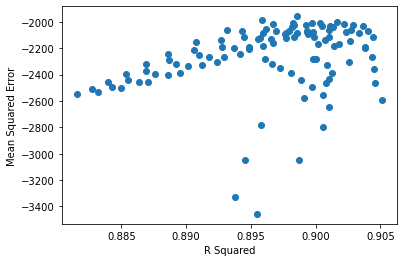

In [97]:
plt.scatter(elastic_poly2['r2'], elastic_poly2['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

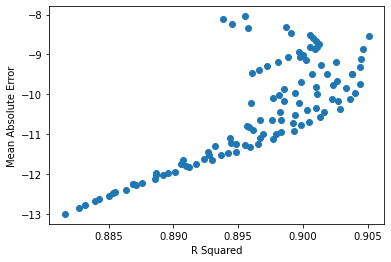

In [99]:
plt.scatter(elastic_poly2['r2'], elastic_poly2['neg_mean_absolute_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Absolute Error")
#plt.title()
plt.show()

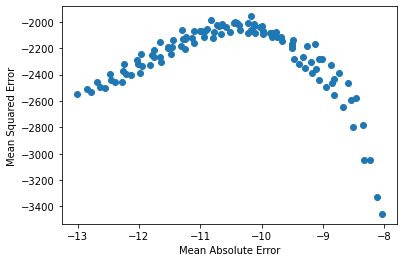

In [100]:
plt.scatter(elastic_poly2['neg_mean_absolute_error'], elastic_poly2['neg_mean_squared_error'])
plt.xlabel("Mean Absolute Error")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

In [95]:
elastic_poly3 = pd.read_csv("elastic_net_fs_search_poly_3.csv")

In [96]:
elastic_poly3

,Unnamed: 0,alpha,l1_ratio,neg_mean_squared_error,r2,neg_mean_absolute_error
0,0,0.1,0.0,-53567.142536,-2.021358,-13.254602
1,1,0.1,0.1,-49133.844007,-1.701197,-13.020245
2,2,0.1,0.2,-45587.552362,-1.448223,-12.798827
3,3,0.1,0.3,-42312.936395,-1.217272,-12.571423
4,4,0.1,0.4,-38058.135634,-0.919537,-12.285157
...,...,...,...,...,...,...
105,105,1.0,0.6,-22059.894465,0.467725,-13.506612
106,106,1.0,0.7,-21101.641656,0.541224,-12.965424
107,107,1.0,0.8,-20477.974213,0.595411,-12.312197
108,108,1.0,0.9,-19852.120047,0.630447,-11.458375


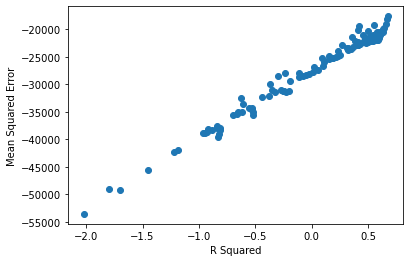

In [98]:
plt.scatter(elastic_poly3['r2'], elastic_poly3['neg_mean_squared_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()

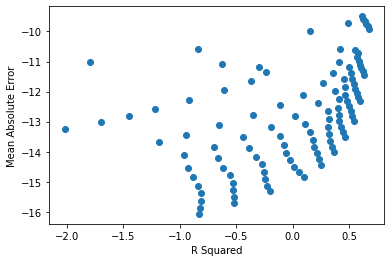

In [101]:
plt.scatter(elastic_poly3['r2'], elastic_poly3['neg_mean_absolute_error'])
plt.xlabel("R Squared")
plt.ylabel("Mean Absolute Error")
#plt.title()
plt.show()

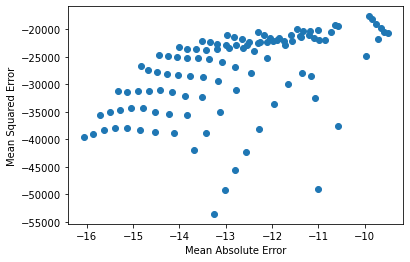

In [102]:
plt.scatter(elastic_poly3['neg_mean_absolute_error'], elastic_poly3['neg_mean_squared_error'])
plt.xlabel("Mean Absolute Error")
plt.ylabel("Mean Squared Error")
#plt.title()
plt.show()